# Seeing time series modelling

In [42]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime, joblib
import statsmodels.api as sm
from itertools import product

In [50]:
# Reading the DataFrame separated by tab
seeing = pd.read_csv('../data/seeing_data.csv', header=0, parse_dates=[0], index_col=0, sep=',')

# Converting the Index into Date column
seeing['Date'] = seeing.index

# Merging Date and Time columns
seeing['Datetime'] = [str(seeing.Date[ii])[:10] + ' ' + str(seeing.Time[ii]) for ii in range(len(seeing))]

# Deleting the two previous columns
seeing.drop(['Date', 'Time'], axis=1, inplace=True)

# Converting the Datetime column into datetime format
seeing.Datetime = pd.to_datetime(seeing['Datetime'])

# Converting Datetime into the index
seeing.index = seeing.Datetime

# Last, deleting the Datetime column
seeing.drop(['Datetime'], axis=1, inplace=True)

# Displaying the first 5 lines
seeing.head()

/tmp/ipykernel_5635/3708277417.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seeing['Datetime'] = [str(seeing.Date[ii])[:10] + ' ' + str(seeing.Time[ii]) for ii in range(len(seeing))]


,Seeing
Datetime,
2020-01-01 00:00:32,1.5096
2020-01-01 00:01:08,1.5786
2020-01-01 00:01:44,1.2777
2020-01-01 00:02:20,1.2360
2020-01-01 00:02:55,1.3859


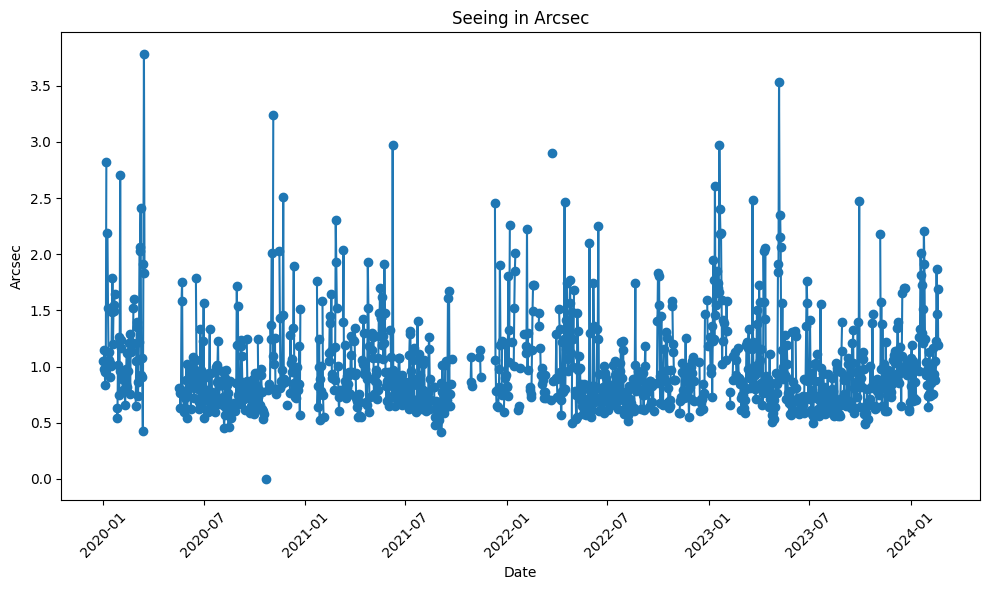

In [52]:
# Resample para agrupar los datos por semana y calcular la media
data_weekly = seeing.resample('D').mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_weekly.index, data_weekly['Seeing'], marker='o')
plt.xlabel('Date')
plt.ylabel('Arcsec')
plt.title('Seeing in Arcsec')
plt.xticks(rotation=45)  # Rotar las fechas para que sean legibles
plt.tight_layout()
plt.show()

## Resampling of the time series

In [60]:
def dat_resample(data):
    # Resamplear los datos a intervalos de 10 minutos (puedes ajustar esto según tus necesidades)
    data_resampled = data.resample('10T').mean()
    
    # Establecemos la frecuencia
    data_resampled = data_resampled.asfreq('10T')
    
    # Eliminamos los posibles NaN
    data_resampled.dropna(inplace = True)

    return data_resampled

# Resampleo de datos cada 10 minutos
data_resampled = dat_resample(seeing)

# Tomamos solo los datos a partir de 2023 para reducir la muestra
data_resampled = data_resampled['2023-01':]

## Time Series Decomposition

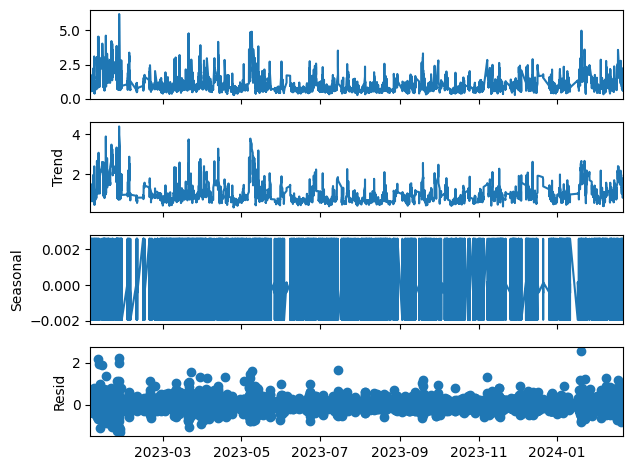

In [67]:
# Descomposición aditiva

# Elgimos un periodo de 144 dado que la función está resampleada cada 10 minutos, y queremos observaro la variación horaria, esto sería
# 1 hora = 60 minutos / 10 minutos = 6

result = seasonal_decompose(data_resampled, model='additive', period=6)

# Graficar los componentes de la descomposición
result.plot()
plt.show()

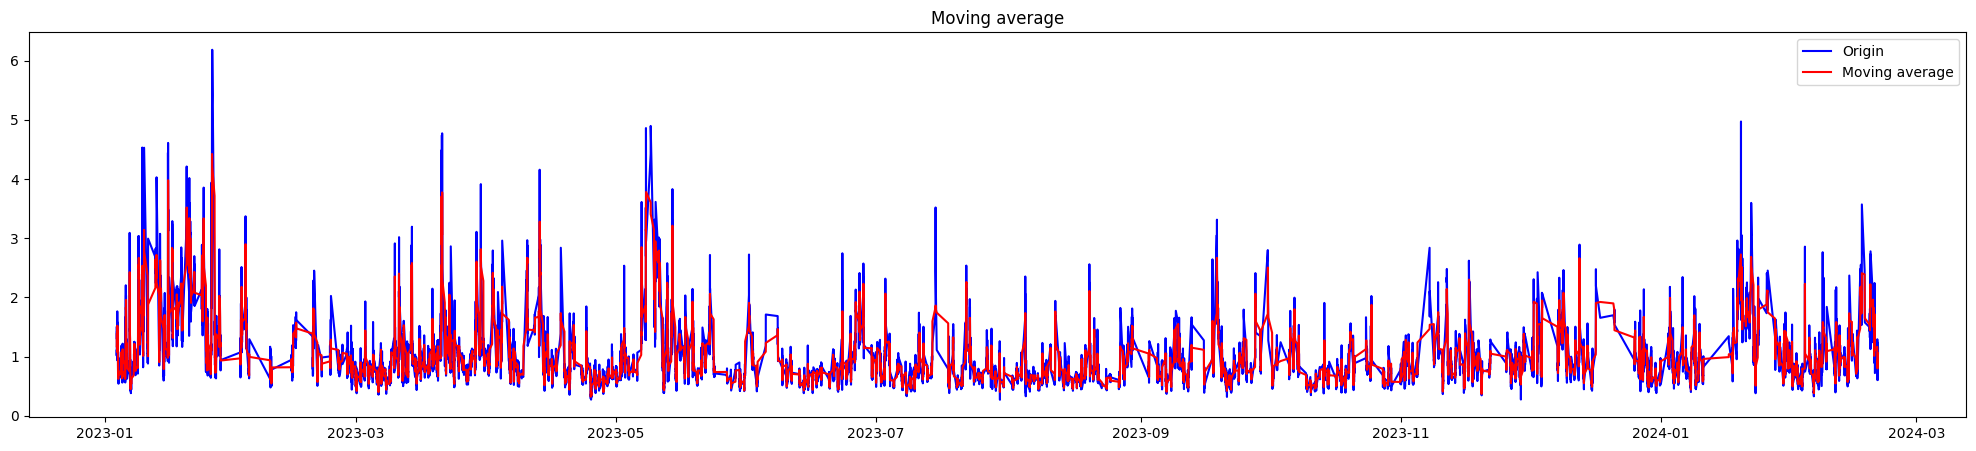

In [66]:
#We have a seasonality of period 6
data_resampled_ma = data_resampled.rolling(window = 6, center = True).mean()
#Series display
plt.figure(figsize=(25,5))
plt.plot(data_resampled, color = 'blue', label = 'Origin')
plt.plot(data_resampled_ma, color = 'red', label = 'Moving average')
plt.legend()
plt.title('Moving average')
plt.show()

## Autocorrelation (ACF) and Partial Autocorrelation (PACF) of the time series

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

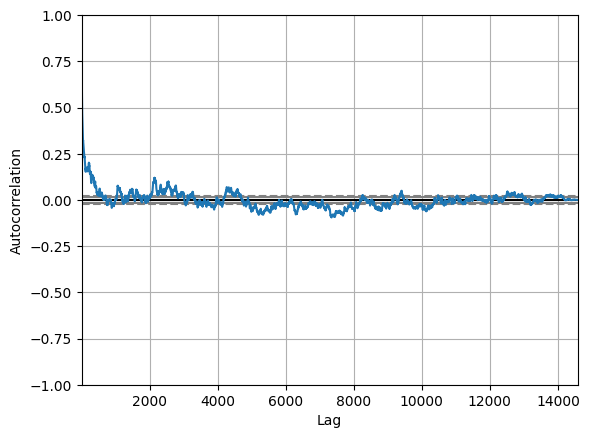

In [68]:
# First, we plot a correlation map
pd.plotting.autocorrelation_plot(data_resampled)

<Figure size 1400x600 with 0 Axes>

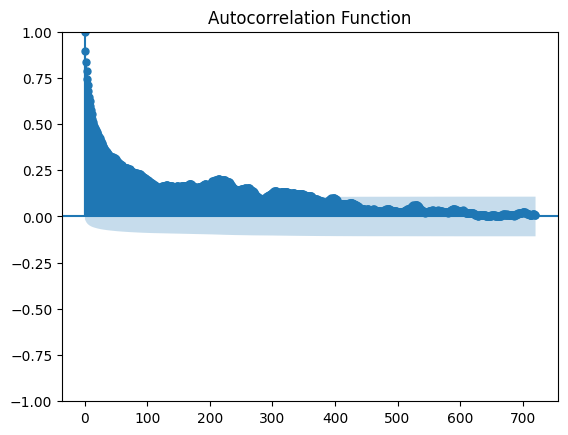

<Figure size 1400x600 with 0 Axes>

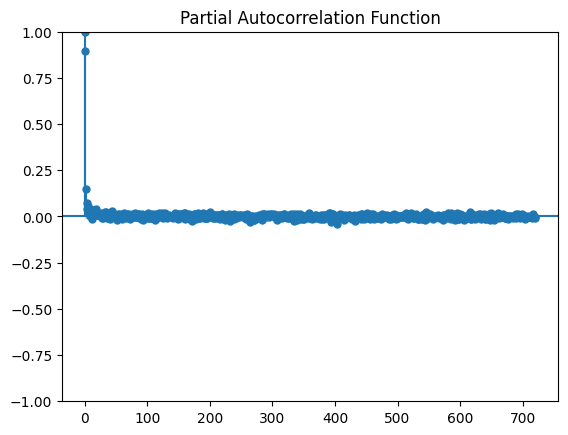

In [71]:
import statsmodels.graphics.tsaplots as tsaplots

# Graficar la función de autocorrelación (ACF)
plt.figure(figsize=(14, 6))
acf = tsaplots.plot_acf(data_resampled.dropna(), lags=144*5, title='Autocorrelation Function')
plt.show()

# Graficar la función de autocorrelación parcial (PACF)
plt.figure(figsize=(14, 6))
pacf = tsaplots.plot_pacf(data_resampled.dropna(), lags=144*5, title='Partial Autocorrelation Function')
plt.show()

## AutoRegressive Process $AR(p)$

In [109]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar el modelo AR(p) con el orden p determinado
p = 4
model_ar = ARIMA(data_resampled, order=(p, 0, 0), seasonal_order=(0, 0, 0, 144)).fit()

# Resumen del modelo
print(model_ar.summary())

/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Seeing   No. Observations:                14581
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1288.220
Date:                Tue, 06 Aug 2024   AIC                          -2564.441
Time:                        20:30:11   BIC                          -2518.916
Sample:                             0   HQIC                         -2549.315
                              - 14581                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9755      0.034     28.698      0.000       0.909       1.042
ar.L1          0.7527      0.003    237.584      0.000       0.746       0.759
ar.L2          0.0874      0.005     17.407      0.0

## Validating the model

### a) Residuals analysis

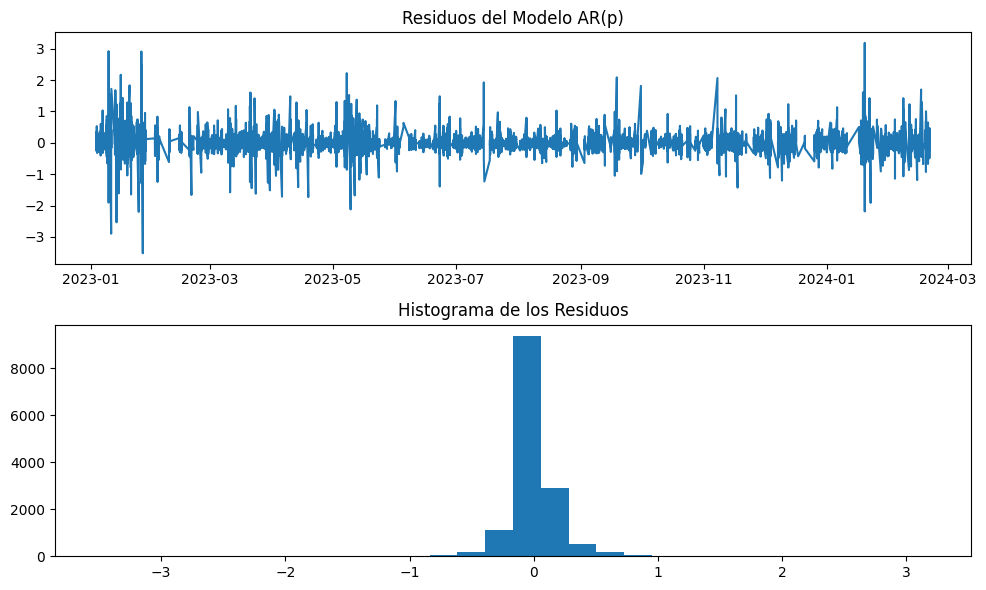

In [110]:
# Graficar los residuos
residuals = model_ar.resid
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuos del Modelo AR(p)')
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30)
plt.title('Histograma de los Residuos')
plt.tight_layout()
plt.show()

### b) Stationarity of the residuals

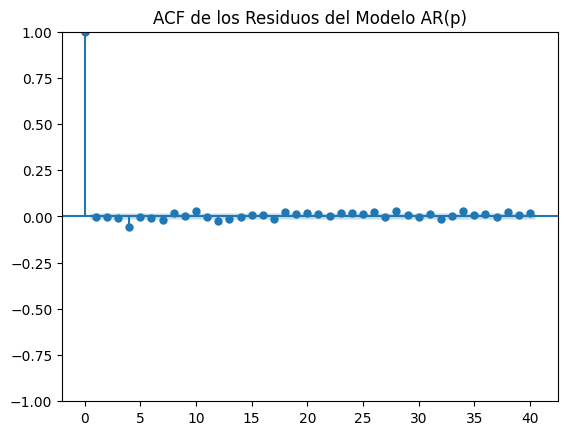

In [111]:
# ACF de los residuos para verificar que no quedan patrones
plot_acf(residuals, lags=40)
plt.title('ACF de los Residuos del Modelo AR(p)')
plt.show()

### c) Checking the Normality and Homoestasicity

In [112]:
from statsmodels.stats.diagnostic import acorr_lm

# Test de Ljung-Box para los residuos
lb_test = acorr_lm(model_ar.resid)
print(f'Ljung-Box test statistic: {lb_test[0]}')
print(f'p-value: {lb_test[1]}')

# Prueba de normalidad de residuos (Shapiro-Wilk Test)
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk test statistic: {stat}')
print(f'p-value: {p_value}')

Ljung-Box test statistic: 67.89987695139158
p-value: 1.1259396069097736e-10
Shapiro-Wilk test statistic: 0.7594573497772217
p-value: 0.0


/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


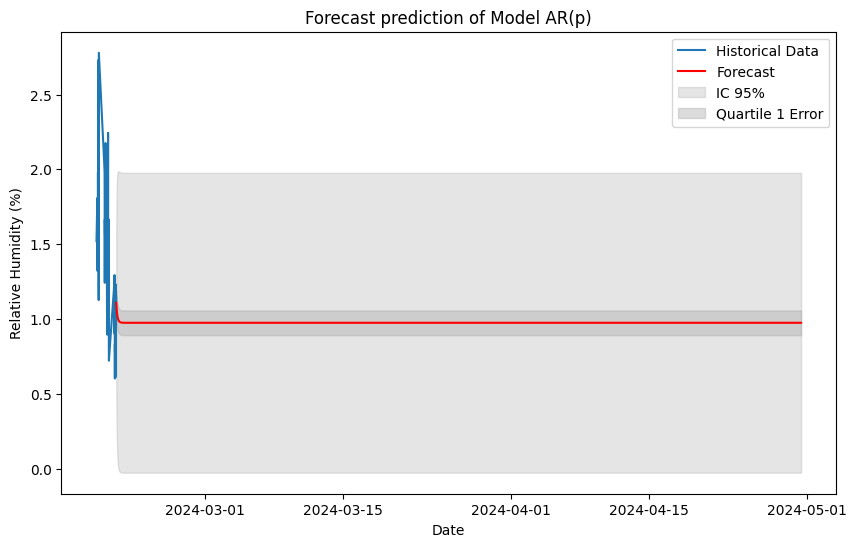

In [113]:
# Realizar pronósticos
steps = 10000
forecast = model_ar.get_forecast(steps=steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Crear una nueva serie temporal para las predicciones
forecast_index = pd.date_range(start=data_resampled.index[-1], periods=steps + 1, freq='10T')[1:]
forecast_series = pd.Series(forecast_mean.values, index=forecast_index)
forecast_lower_series = pd.Series(forecast_ci['lower Seeing'].values, index=forecast_index)
forecast_upper_series = pd.Series(forecast_ci['upper Seeing'].values, index=forecast_index)

# Seleccionar el último periodo de datos históricos desde 2024-01 en adelante
data_recent = data_resampled['2024-02-19 00:00:00':'2024-02-20 23:50:00']

# Calcular los errores del pronóstico
# Aseguramos que forecast_mean y data_recent tienen la misma longitud para la resta
if len(data_recent) < steps:
    historical_steps = len(data_recent)
else:
    historical_steps = steps

# Alinear los índices para que la resta sea válida
aligned_forecast_mean = forecast_mean[:historical_steps].values
aligned_data_recent = data_recent.iloc[:historical_steps]['Seeing'].values
errors = aligned_data_recent - aligned_forecast_mean

# Calcular el cuartil 1 de los errores
q1 = np.quantile(errors, 0.25)

# Crear el área de cuartil 1 para graficar
forecast_q1_lower = forecast_series - q1
forecast_q1_upper = forecast_series + q1

# Graficar los datos históricos recientes y las predicciones con el intervalo de confianza
plt.figure(figsize=(10, 6))
plt.plot(data_recent, label='Historical Data')
#plt.plot(data_resampled_2024['2024-01-01':'2024-01-10'], 'k-.', label='2024 Data',alpha=0.5)
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_lower_series, forecast_upper_series, color='gray', alpha=0.2, label='IC 95%')
plt.fill_between(forecast_index, forecast_q1_lower, forecast_q1_upper, color='darkgray', alpha=0.4, label='Quartile 1 Error')
plt.title('Forecast prediction of Model AR(p)')
plt.xlabel('Date'); plt.ylabel('Relative Humidity (%)')
plt.legend()
plt.show()